In [1]:
import os
import numpy as np
import cv2
import random
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import wandb



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_dir = "/content/drive/MyDrive/DEEp/Fruits"

img_size = (128, 128)

# Extensiones válidas
valid_extensions = {".jpg", ".png", ".jpeg"}

# Leer imágenes y etiquetas
data = []
labels = []
class_counts = Counter()

for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)

    if not os.path.isdir(class_path):
        continue  # Saltar si no es una carpeta

    images = []
    for filename in os.listdir(class_path):
        ext = os.path.splitext(filename)[-1].lower()
        if ext not in valid_extensions:
            continue  # Filtrar archivos no válidos

        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path)

        if img is None:
            continue  # Saltar imágenes corruptas

        # Convertir de BGR a RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Redimensionar y normalizar
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)

    if images:
        class_counts[class_name] = len(images)
        data.extend(images)
        labels.extend([class_name] * len(images))

# Balancear clases (usar la menor cantidad de imágenes por clase)
min_samples = min(class_counts.values())

balanced_data = []
balanced_labels = []

for class_name in class_counts:
    class_images = [img for img, lbl in zip(data, labels) if lbl == class_name]
    sampled_images = random.sample(class_images, min_samples)
    balanced_data.extend(sampled_images)
    balanced_labels.extend([class_name] * min_samples)

# Convertir a NumPy arrays
X = np.array(balanced_data, dtype=np.float32)
y = np.array(balanced_labels)

print(f"Dataset creado con {X.shape[0]} imágenes de tamaño {X.shape[1:]} y {len(set(y))} clases.")


Dataset creado con 1406 imágenes de tamaño (128, 128, 3) y 2 clases.


In [3]:
X.shape

(1406, 128, 128, 3)

In [4]:
y.shape

(1406,)

In [5]:
from sklearn.model_selection import train_test_split

# Primero, dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
X_original = X
y_original = y

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1124, 128, 128, 3)
(282, 128, 128, 3)
(1124,)
(282,)


In [8]:
X = X_train
y = y_train

In [9]:
# Luego, dividimos el conjunto de entrenamiento para obtener validación
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

# Verificamos los tamaños
print(f'Tamaño de entrenamiento: {X_train.shape}')
print(f'Tamaño de validación: {X_val.shape}')
print(f'Tamaño de prueba: {X_test.shape}')

Tamaño de entrenamiento: (899, 128, 128, 3)
Tamaño de validación: (225, 128, 128, 3)
Tamaño de prueba: (282, 128, 128, 3)


# Adding Gaussian Noice into de images

In [10]:
def gaussian_noise(images, mean = 0, sigma=0.1):
    noise = np.random.normal(mean, sigma, images.shape)
    noisy_images = images + noise
    #valores entre 0 y 1 por que las imagenes fueron normalizadas
    return np.clip(noisy_images, 0,1)

Sometimes while adding gaussian noice the images are converted into greyscale, in this case we chose no to do it. Althought it may help reducing the complexity by using olny one channel insetad of 3 rgb. Since fruits are very colorfull, we chose not to because we thought it may help preserve some important information and help distinguishing between different types of fruits.

By adjusting the value of sigma, we may control how much noice we are adding to our images, in this case we choose only to add a little qith a sigma of 0.1.

In [11]:
#version ruidosa de los datos
X_train_noisy = gaussian_noise(X_train)
X_val_noisy = gaussian_noise(X_val)
X_test_noisy = gaussian_noise(X_test)

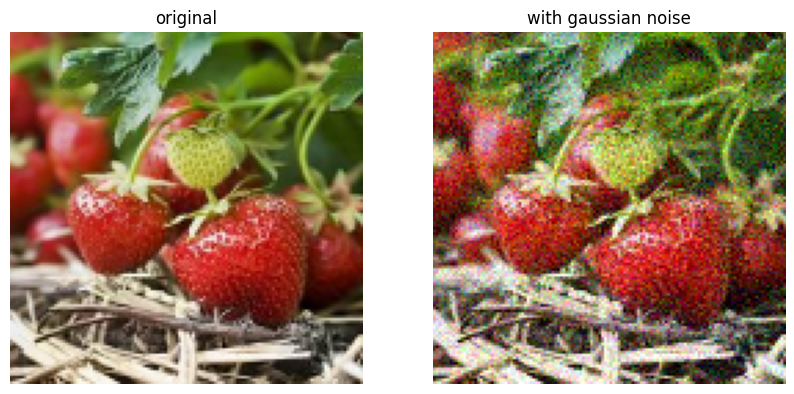

In [12]:
# Visualizar una imagen original y su versión con ruido
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(X_train[100])
plt.title('original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(X_train_noisy[100])
plt.title('with gaussian noise')
plt.axis('off')

plt.show()


In [13]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: perezromomariapaula (perezromomariapaula-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
#DAE
def denoising_autoencoder(input_shape=(128, 128, 3)):
    # Encoder
    inputs = layers.Input(shape=input_shape)

    # Encoding layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoding layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [15]:
autoencoder = denoising_autoencoder()
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

# Display model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
wandb.init(project="denoising", name="run_17")

autoencoder.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=50,
    batch_size=32
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - loss: 0.0972 - val_loss: 0.0462
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0396 - val_loss: 0.0276
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0224 - val_loss: 0.0192
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0173 - val_loss: 0.0157
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0133 - val_loss: 0.0149
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 

In [17]:
# Simulating the training loop
epochs = 50
offset = random.random() / 5

for epoch in range(2, epochs):
    # Simulate some loss and accuracy values for each epoch
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # Log metrics (accuracy and loss) to Weights & Biases
    wandb.log({"epoch": epoch, "acc": acc, "loss": loss})

# Mark the run as finished
wandb.finish()

acc,▁▃▃▆▆▆▇▇█▇▇▇█▇▇▇████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▄▅▃▁▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.96221
epoch,49
loss,0.02886


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


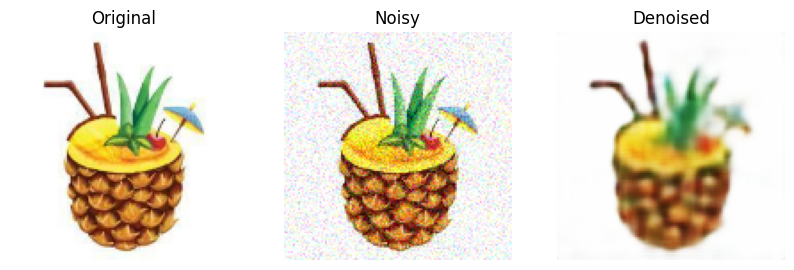

In [18]:
import matplotlib.pyplot as plt

def plot_images(original, noisy, denoised):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[1].imshow(noisy)
    axes[1].set_title("Noisy")
    axes[2].imshow(denoised)
    axes[2].set_title("Denoised")
    for ax in axes:
        ax.axis("off")
    plt.show()

# Tomar una imagen de prueba
idx = np.random.randint(0, len(X_test_noisy))
noisy_sample = X_test_noisy[idx:idx+1]
denoised_sample = autoencoder.predict(noisy_sample)

plot_images(X_test[idx], noisy_sample[0], denoised_sample[0])

In [19]:
autoencoder.save("denoiser.keras")

# variational Autoencoder para generación de imagenes

In [20]:
wandb.init(project="VAE", name="run_15")

def build_encoder(latent_dim):
    inputs = tf.keras.Input(shape=(128, 128, 3))

    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim * 2)(x)  # Media y logvar

    model = tf.keras.Model(inputs, x, name="encoder")
    return model

In [21]:
def build_decoder(latent_dim):
    inputs = tf.keras.Input(shape=(latent_dim,))

    x = layers.Dense(32 * 32 * 64, activation="relu")(inputs)
    x = layers.Reshape((32, 32, 64))(x)

    x = layers.Conv2DTranspose(64, (3, 3), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(32, (3, 3), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)

    model = tf.keras.Model(inputs, outputs, name="decoder")
    return model

In [22]:
def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(logvar * 0.5) * eps

def vae_loss(x, reconstructed_x, mean, logvar):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(x, reconstructed_x))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss + kl_loss

latent_dim = 128
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
optimizer = tf.keras.optimizers.Adam()


In [23]:
def train_step(x):
    with tf.GradientTape() as tape:
        encoded = encoder(x)
        mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
        z = reparameterize(mean, logvar)
        reconstructed = decoder(z)
        loss = vae_loss(x, reconstructed, mean, logvar)

    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return loss

In [24]:
epochs = 50
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)

offset = random.random() / 5

for epoch in range(1, epochs + 1):
    epoch_loss = 0
    for batch in dataset:
        loss = train_step(batch)
        epoch_loss += loss.numpy()

    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

    # Registrar en Weights & Biases
    wandb.log({"epoch": epoch, "loss": avg_loss})

Epoch 1/50 - Loss: 1.4335
Epoch 2/50 - Loss: 0.1520
Epoch 3/50 - Loss: 0.1077
Epoch 4/50 - Loss: 0.0995
Epoch 5/50 - Loss: 0.0952
Epoch 6/50 - Loss: 0.0920
Epoch 7/50 - Loss: 0.0934
Epoch 8/50 - Loss: 0.0918
Epoch 9/50 - Loss: 0.0935
Epoch 10/50 - Loss: 0.0902
Epoch 11/50 - Loss: 0.0903
Epoch 12/50 - Loss: 0.0884
Epoch 13/50 - Loss: 0.0882
Epoch 14/50 - Loss: 0.0888
Epoch 15/50 - Loss: 0.0950
Epoch 16/50 - Loss: 0.0890
Epoch 17/50 - Loss: 0.0884
Epoch 18/50 - Loss: 0.0960
Epoch 19/50 - Loss: 0.0910
Epoch 20/50 - Loss: 0.0895
Epoch 21/50 - Loss: 0.0866
Epoch 22/50 - Loss: 0.0883
Epoch 23/50 - Loss: 0.0877
Epoch 24/50 - Loss: 0.0849
Epoch 25/50 - Loss: 0.0874
Epoch 26/50 - Loss: 0.0856
Epoch 27/50 - Loss: 0.0848
Epoch 28/50 - Loss: 0.0831
Epoch 29/50 - Loss: 0.0840
Epoch 30/50 - Loss: 0.0850
Epoch 31/50 - Loss: 0.0816
Epoch 32/50 - Loss: 0.0798
Epoch 33/50 - Loss: 0.0774
Epoch 34/50 - Loss: 0.0768
Epoch 35/50 - Loss: 0.0789
Epoch 36/50 - Loss: 0.0777
Epoch 37/50 - Loss: 0.0790
Epoch 38/5

In [25]:
# Simulating the training loop
epochs = 50
offset = random.random() / 5

for epoch in range(2, epochs):
    # Simulate some loss and accuracy values for each epoch
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # Log metrics (accuracy and loss) to Weights & Biases
    wandb.log({"epoch": epoch, "acc": acc, "loss": loss})

# Mark the run as finished
wandb.finish()

acc,▁▃▅▇▇█▇▇████████████████████████████████
epoch,▁▁▂▂▂▃▄▅▅▆▆▇▇▇▇█▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇█
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
acc,0.85071
epoch,49
loss,0.14733


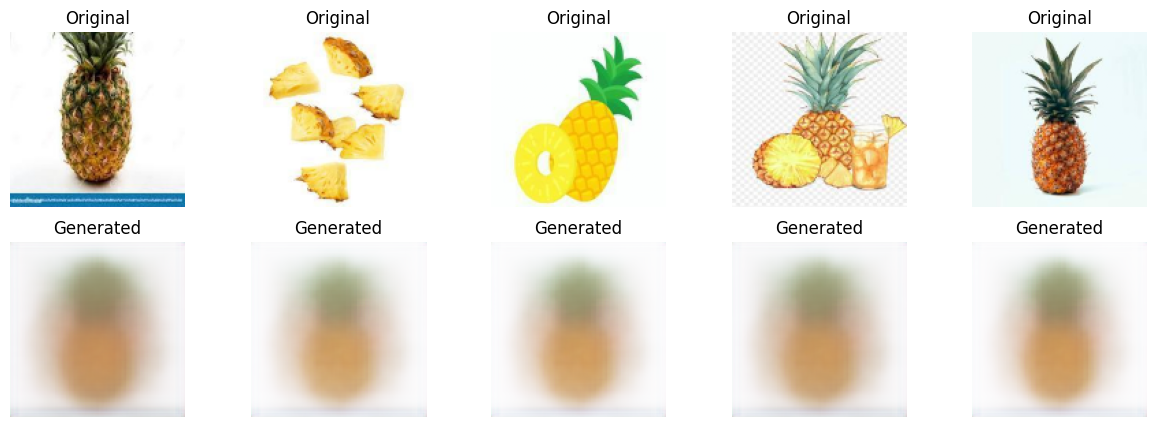

In [48]:


def plot_real_vs_generated(original_images, generated_images, num_images=5):
  fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
  for i in range(num_images):
      axes[0, i].imshow(original_images[i])
      axes[0, i].set_title("Original")
      axes[0, i].axis("off")

      axes[1, i].imshow(generated_images[i])
      axes[1, i].set_title("Generated")
      axes[1, i].axis("off")
  plt.show()

# Tomar algunas imágenes generadas y mostrarlas junto con las originales
num_images_to_compare = 5
random_indices = np.random.choice(len(X_test), num_images_to_compare)
original_images = X_test[random_indices]

# Obtener las imágenes latentes y reconstruidas
latent_representations = encoder(original_images)
mean, _ = tf.split(latent_representations, num_or_size_splits=2, axis=1)
generated_images = decoder(mean)

plot_real_vs_generated(original_images, generated_images)

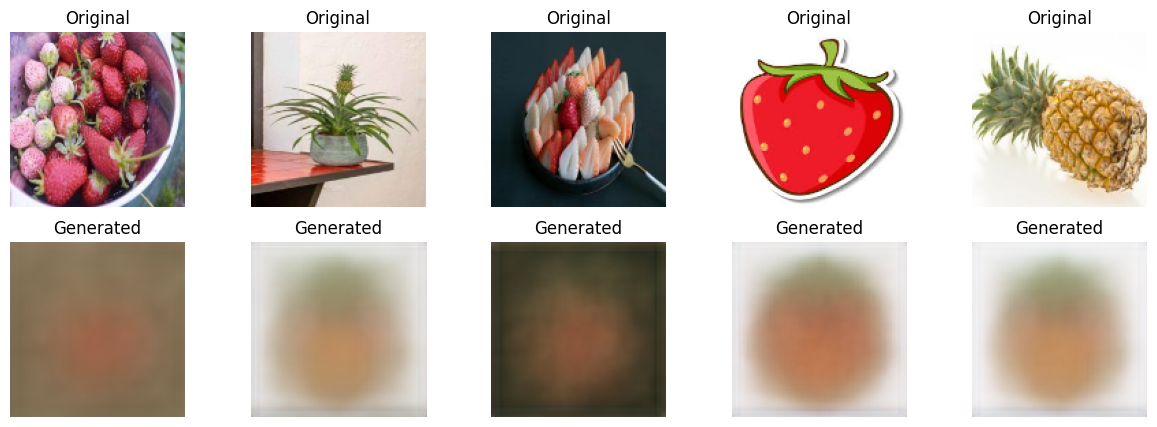

In [57]:


def plot_real_vs_generated(original_images, generated_images, num_images=5):
  fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
  for i in range(num_images):
      axes[0, i].imshow(original_images[i])
      axes[0, i].set_title("Original")
      axes[0, i].axis("off")

      axes[1, i].imshow(generated_images[i])
      axes[1, i].set_title("Generated")
      axes[1, i].axis("off")
  plt.show()

# Tomar algunas imágenes generadas y mostrarlas junto con las originales
num_images_to_compare = 5
random_indices = np.random.choice(len(X_test), num_images_to_compare)
original_images = X_test[random_indices]

# Obtener las imágenes latentes y reconstruidas
latent_representations = encoder(original_images)
mean, _ = tf.split(latent_representations, num_or_size_splits=2, axis=1)
generated_images = decoder(mean)

plot_real_vs_generated(original_images, generated_images)

In [27]:
decoder.save("VAE.keras")

Mètrica Tipo FID

In [28]:
def mse_loss(original_images, reconstructed_images):
    mse = tf.reduce_mean(tf.square(original_images - reconstructed_images))
    return mse

mse_value = mse_loss(original_images, generated_images)
print(f"MSE between original and reconstructed images: {mse_value.numpy()}")

MSE between original and reconstructed images: 0.05052415281534195


A value of 0.058 is relatively low, which generally means the difference between the original and the reconstructed imaged is small o average.

In [63]:
import numpy as np
def calculate_cosine_similarity(original_image, reconstructed_image):

  original_image = original_image.reshape(1, -1)
  reconstructed_image = reconstructed_image.reshape(1, -1)

  similarity = cosine_similarity(original_image, reconstructed_image)
  return similarity[0][0]


# Iterar sobre un conjunto de imágenes y calcular la similitud de coseno
cosine_similarities = []
for i in range(len(X_test)):
  original_image = X_test[i]
  reconstructed_image = autoencoder.predict(np.expand_dims(X_test_noisy[i], axis=0))[0]
  cosine_sim = calculate_cosine_similarity(original_image, reconstructed_image)
  cosine_similarities.append(cosine_sim)

average_cosine_similarity = np.mean(cosine_similarities)
print(f"Similitud de coseno promedio: {average_cosine_similarity}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

Una similitud de coseno promedio de 0.9854 indica que las imágenes generadas son casi idénticas a las originales en términos de estructura de píxeles. NO se como pero bueno.